
# Monolithic solver (Lagrange and DG formulation)

.. index::
   triple: Equations; Stokes; Saddle-Point;

.. index:: Methods; Mixed FEM

.. index:: Spaces; Taylor-Hood

.. index:: Spaces; Combined

.. sectionauthor:: contribution by Benjamin Terschanski

This example shows how to work with composite spaces of different polynomial order
to construct LBB stable pairs for velocity and pressure approximations.

Consider the stationary stokes problem with Newtonian stress on a unit square $\Omega = [0,\,1]^2$.
Governing Equations are

\begin{align}
-\mu\nabla^2\mathbf{u} + \nabla p &= \mathbf{f} \qquad \text{Conservation of Momentum} \\
-\nabla \cdot \mathbf{u} &= 0 \qquad \text{Conservation of Mass} \\
\end{align}

The problem is closed with Dirichlet boundary conditions
$$u = u_D \quad \text{on} \partial\Omega$$

where $u_D = u_D(x,y)$ will be taken from the analytical solution of the testcase defined later.
Please note that the weak forms defined here assume Dirichlet velocity boundary conditions on
the entire domain boundary $\partial \Omega$ and we thus avoid having to distinguish between
Dirichlet and non-Dirichlet parts of the exterior boundary `ds`.

We first introduce a discrete domain $\Omega_h$ with a structured quadrilateral grid:

In [1]:
from matplotlib import pyplot

from dune.grid import structuredGrid
from dune.ufl import cell
from ufl import SpatialCoordinate, FacetNormal
import numpy as np

gridView = structuredGrid([0, 0], [1, 1], [7, 7])
dim_space = gridView.dimGrid

spatial_coordinate = SpatialCoordinate(cell(dim_space))

A weak form of stationary stokes problem reads
$$ \mu\int_{\Omega_h} \nabla\mathbf{u_h}:\nabla\mathbf{v_h}\,\mathrm{d}x - \underline{\int_{\partial\Omega_h} (\nabla\mathbf{u_h}\cdot \mathbf{n})\cdot\mathbf{v}_h \, \mathrm{d}s} - \int_{\Omega_h} p_h\,\nabla\cdot\mathbf{v_h} \,\mathrm{d}x + \underline{\int_{\partial\Omega_h} p_h\,\mathbf{v}_h\cdot\mathbf{n}\, \mathrm{d}s} = \int_\Omega \mathbf{f}\cdot\mathbf{v}_h\,\mathrm{d}x $$

$$  \int_{\Omega_h} \nabla\cdot\mathbf{u_h}\, q_h\,\mathrm{d}x = 0 $$

where the underlined terms vanish if $\mathbf{v_h} \in H_0^1(\Omega_h)$.
Here, $\mathbf{u_h}$ and $\mathbf{v_h}$ $\in V_h$ denote vector-valued (in our case 2D) trial- and test-functions for the velocity,
$p_h$ and $q_h$ $\in Q_h$ denote trial- and test-function for the pressure.
In this example we will chose $V_h$ and $Q_h$ as polynomial spaces of order $P^k$ and $P^{k-1}$ for velocity
and pressure respectively ("Taylor-Hood Elements"). This combination is well-known for being LBB-stable / satisfying
a discrete inf-sup condition for the problem at hand, which is a prerequisite to guarantee well-posedness of the
primal form we are using.

On the DUNE side we start by initializing some geometric / ufl variables
(some will only be needed later on for the DG version of our approximation).

In [2]:
from ufl import div, grad, dot, inner, dS, dx, ds, jump, avg, CellVolume, FacetArea, MinCellEdgeLength, MinFacetEdgeLength, conditional
from dune.ufl import Constant
import numpy as np

# Surface normal on the exterior boundary
n  = FacetNormal(cell(dim_space))

# each element facet has sides + | - with normal ne=n('+') pointing
# from + to - ( meaning + |-> -)
# in the notation of the paper: superscript "int" == ('+'), "ext" == ('-')
# see (BDK12) for more details
ne = n('+')

# Representative element length for interior facets
h_int = avg(CellVolume(cell(dim_space))) / FacetArea(cell(dim_space))

# Representative element length for exterior facets (boundaries)
h_ext = CellVolume(cell(dim_space)) / FacetArea(cell(dim_space))

# Penalization of discontinuities / boundary value
sigma_ip = Constant(1000, name="interior_penalty_parameter")

## Taylor-Hood formulation

We now define the weak form of the stokes problem, first in a standard Continuous Galerkin (CG) setting:

In [3]:
def weak_form_stationary_stokes(u,v,p,q, f,mu, dirichlet_velocity=None):
    """
    Return weak form for the stationary stokes problem, given a set of trial and test basis
    functions for velocity and pressure.

    This weak form corresponds to the canonical saddle point problem.

    :param u: (vector-valued) trial function for velocity (in R^d)
    :param v: (vector-valued) test function for velocity (in R^d)
    :param p: (scalar) trial function for pressure (in R)
    :param q: (scalar) test function for pressure (in R)
    """

    # Note: This assumes Dirichlet Velocity BCs everywhere so we don't need
    # the boundary integrals which are shown here for completeness
    viscous_stress = mu*inner(grad(u), grad(v))*dx # - inner(dot(grad(u),n), v)*ds

    pressure_force = -p*div(v)*dx # + p*dot(v,n)*ds
    continuity = div(u)*q*dx

    lhs_terms = viscous_stress + pressure_force + continuity

    if (dirichlet_velocity!=None):
        """
        `dirichlet_velocity` input argument can be used to enforce
        velocity Dirichlet BCs weakly (e.g. by penalizing deviations of u
        from `dirichlet_velocty` on the boundary, "Nietzsche's Method")
        """
        nietzsche_terms = (sigma_ip/h_ext)*dot(u-dirichlet_velocity, v)*ds
        lhs_terms += nietzsche_terms


    return lhs_terms == dot(f, v)*dx

### Bercovier-Engelmann Testcase

[Reference case with analytical solution](https://numtourcfd.pages.math.cnrs.fr/doc/NumtourCFD/v1.0.1-alpha.2/applications/validation/bercovier-engelman.html) which was
originally published in <cite data-cite="BERCOVIER79"></cite>.
Equations for $f$ are taken from the benchmark document
<cite data-cite="TrioCFD"></cite>:

$$ \Omega = [0,\,1]^2$$

With $\mu\equiv 1$ the problem has the analytical solution
\begin{align*}
u(x,y) &= -256\,y\,(y-1)\,(2\,y -1)\,x^2\,(x-1)^2 \\
v(x,y) &= 256\,x\,(x-1)\,(2\,x-1)\,y^2\,(y-1)^2 \\
p &= (x-0.5)\,(y-0.5) \\
\mathbf{f} &= (f_1(x,\,y) + (y-0.5), -f_1(y,\,x) + (x-0.5))^T
\end{align*}
where $f_1(x,\,y) = 256\,[x^2\,(x-1)^2\,(12\,y-6) + y\,(y-1)\,(2\,y-1)(12\,x^2 -12\,x + 2) ]$


In [4]:
from dune.ufl import DirichletBC
from ufl import as_vector
from dune.fem.function import gridFunction

x = spatial_coordinate[0]
y = spatial_coordinate[1]

u_exact = gridFunction(-256*y*(y-1)*(2*y-1)*x**2*(x-1)**2,
                      gridView,
                      name="analytical_solution_x",
                      order=5)
v_exact = gridFunction(256*x*(x-1)*(2*x-1)*y**2*(y-1)**2,
                      gridView,
                      name="analytical_solution_y",
                      order=5)
p_exact = gridFunction((x-0.5)*(y-0.5),
                      gridView,
                      name="analytical_solution_pressure",
                      order=5)
def f_1(x,y):
    return 256*(x**2*(x-1)**2*(12*y-6) + y*(y-1)*(2*y-1)*(12*x**2 -12*x + 2))
f_exact = gridFunction(as_vector([f_1(x,y) + (y-0.5), -f_1(y,x) + (x-0.5)]),
                      gridView,
                      name="analytical_solution_force_term",
                      order=5)

mu = 1

Continuous Galerkin (CG) setup

In [5]:
print("\n")
print("----------------------")
print("Set up composite space and scheme in CG setting: \n")
from dune.fem.space import lagrange, composite
from ufl import TrialFunction, TestFunction, as_vector, eq, conditional
from dune.fem.scheme import galerkin as solutionScheme
from dune.ufl import BoundaryId

velocity_order = 3
space_velocity = lagrange(gridView,
                          dimRange=dim_space,
                          order=velocity_order,
                          storage="numpy")

space_pressure = lagrange(gridView,
                          dimRange=1,
                          order=velocity_order-1,
                          storage="numpy")

taylor_hood_space = composite(space_velocity, space_pressure, components=["velocity", "pressure"])

U     = TrialFunction(taylor_hood_space)
V     = TestFunction(taylor_hood_space)

u_h = as_vector([U[0], U[1]])
v_h = as_vector([V[0], V[1]])
p_h = U[2]
q_h = V[2]

is_left  = eq(BoundaryId(taylor_hood_space),1)
is_right = eq(BoundaryId(taylor_hood_space),2)
is_bot   = eq(BoundaryId(taylor_hood_space),3)
is_top   = eq(BoundaryId(taylor_hood_space),4)

dirichlet_bcs_exact   = [DirichletBC(taylor_hood_space, [u_exact, v_exact, None], is_left),
                         DirichletBC(taylor_hood_space, [u_exact, v_exact, None], is_right),
                         DirichletBC(taylor_hood_space, [u_exact, v_exact, None], is_bot),
                         DirichletBC(taylor_hood_space, [u_exact, v_exact, None], is_top)]

print("velocity element order: " + str(taylor_hood_space.subSpaces[0].order))
print("pressure element order: " + str(taylor_hood_space.subSpaces[1].order))

solution_vector_cg = taylor_hood_space.interpolate([0]*(dim_space+1), name="solution_vector_cg")

print("solution_vector.order = " + str(solution_vector_cg.order))

solver_parameters ={"nonlinear.tolerance": 1e-10,
                    "nonlinear.verbose": False,
                    "linear.tolerance": 1e-14,
                    "linear.preconditioning.method": "ilu",
                    "linear.verbose": False,
                    "linear.maxiterations": 1000}

# Alternative (commented) version uses weakly imposed boundary conditions:
# eqns = weak_form_stationary_stokes(u_h, v_h, p_h, q_h, f_exact, mu, as_vector([u_exact, v_exact]))

eqns =  [weak_form_stationary_stokes(u_h, v_h, p_h, q_h, f_exact, mu), *dirichlet_bcs_exact]
scheme_taylor_hood_cg = solutionScheme(eqns,
                                       space=taylor_hood_space,
                                       parameters=solver_parameters,
                                       solver=("istl", "bicgstab"))





----------------------
Set up composite space and scheme in CG setting: 



velocity element order: 3
pressure element order: 2
solution_vector.order = 3



.. note:: **Linear solvers and preconditioning**: The matrix arising from the stokes discretization with mixed fem
is indefinite and solving the linear system with iterative solvers can become challenging (to impossible)
without proper preconditioning. For this toy problem, a combination of incomplete LU preconditioning
and `bicgstab` works well. Other options include direct solvers or using Schur-complement preconditioners,
due to the block structure of the Stokes matrix

Test solve with CG on the toy mesh:

In [6]:
print("\n")
print("----------------------")
print("Test solve with continuous galerkin on the base mesh: \n")
sigma_ip.value = 100
solution_vector_cg.interpolate([0]*(dim_space+1))
output = scheme_taylor_hood_cg.solve(target = solution_vector_cg)
print("Solve finished! \n")
print("number linear iterations: " + str(output['linear_iterations']))



----------------------
Test solve with continuous galerkin on the base mesh: 



Solve finished! 

number linear iterations: 13


Here is a plot of the pressure and velocity field:

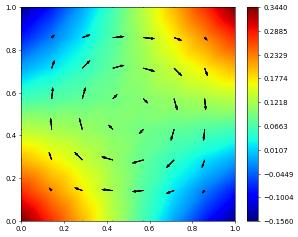

In [7]:
fig = pyplot.figure()
solution_vector_cg.plot(vectors=[0,1], gridLines=None, figure=fig)
solution_vector_cg[2].plot(figure=fig, gridLines=None)

## DG formulation

In the DG framework the weak form becomes more complicated because
we have to deal with a discontinuous basis. The discontinuities
yield a bunch of jump terms on the inter-element boundaries (*interior facets*)
that we have to approximate. A full coverage of the DG setup is beyond the
scope of this tutorial, the references below can serve as starting point.
TODO add reference

In [8]:
# Switch for interior penalty stabilization method
# -1: symmetric interior penalty (SIP)
#  1: non-symmetric " " (NIPG)
#  0: stabilization off
method_switch_ip = Constant(-1.0, name="switch_interior_penalty_method")


gamma_grad_div = Constant(0.0, name="grad_div_stab_param")
"""
Switch / penalty parameter for "grad/div"-type stabilization term,
adds an additional penalization of the discrete divergence
(gamma_grad_div*div(v_h)*div(u_h)*dx ) where u_h, v_h are trial-
and test-functions for velocity.

See also Eqn. (41) of
https://doi.org/10.48550/arXiv.1711.04442 for the definition
and further discussion.
"""

gamma_mass_flux = Constant(0.0, name="mass_flux_stab_param")
"""
Switch / penalty parameter for "mass-flux" stabilization, e.g.
a penalization of deviations of the velocity from the H1_div
space. More precisely, jumps in the normal component of the
discrete velocity are penalized, yielding a "better" element-local mass
conservation.

This could be intuitively thought of as
pushing the solution from a DG approximation space to behave like
a solution from a H_div conforming space (RT, ...).
Full discussion in https://doi.org/10.48550/arXiv.1711.04442 , see Eqn. (18)

"""
gamma_stab_cburn = Constant(0.0, name="stab_cburn")
"""
Gamma from Eqn (19) for the stabilization term j0 defined in Eqn (18)
of https://doi.org/10.1016/j.cma.2018.07.019
"""


def c_h_cburn(p,q):
    """ Stabilization term from https://doi.org/10.1016/j.cma.2018.07.019 (Eqn. 19)"""
    return gamma_stab_cburn*h_int*dot(jump(p)*ne, jump(q)*ne)*dS



def weak_form_stationary_stokes_dg(u,v,p,q,f,mu, is_dirichlet_velocity, dirichlet_value_velocity):
    """
    Return weak form for the stationary stokes problem, given a set of trial and test basis
    functions for velocity and pressure. The viscous stress is discretized
    with SIPG.

    The exact DG form / fluxes correspond to the method documented in https://doi.org/10.48550/arXiv.1711.04442
    In particular, viscous_stress = a(u, v), pressure_force = b(v,p)

    :param u: (vector-valued) trial function for velocity (in R^d)
    :param v: (vector-valued) test function for velocity (in R^d)
    :param p: (scalar) trial function for pressure (in R)
    :param q: (scalar) test function for pressure (in R)
    """

    # Interior penalty stabilization of viscous terms and penalization
    # of jump discontinuities (also used to weakly enforce Dirichlet BCs in the
    # last term)

    viscous_stress = inner(grad(u), grad(v))*dx \
                   - dot(avg(grad(u))*ne, jump(v))*dS \
                   - dot(grad(u)*n, v)*is_dirichlet_velocity*ds \
                   + method_switch_ip*dot(avg(grad(v))*ne, jump(u))*dS \
                   + method_switch_ip*dot(grad(v)*n, u  - dirichlet_value_velocity)*is_dirichlet_velocity*ds \
                   + (sigma_ip/h_int)*dot(jump(u),jump(v))*dS \
                   + (sigma_ip/h_ext)*dot(u - dirichlet_value_velocity,v)*is_dirichlet_velocity*ds

    #2: pressure_force = b_div(v, p)
    pressure_force = - p*div(v)*dx \
                     + avg(p)*dot(jump(v), ne)*dS \
                     + p*dot(v,n)*ds

    # Optional stabilization terms, can be turned off by setting gamma_grad_div.value = 0, gamma_mass_flux.value = 0
    # TODO: do we need mu for the stabilization (which one)?
    grad_div_stabilization = gamma_grad_div*div(u)*div(v)*dx
    mass_flux_stabilization = gamma_mass_flux*((1/h_int)*dot(jump(u),ne)*dot(jump(v),ne)*dS \
                                              +(1/h_ext)*dot(u - dirichlet_value_velocity, n)*dot(v, n)*ds )
    pressure_stabilization = c_h_cburn(p, q)
    stab_terms = grad_div_stabilization + mass_flux_stabilization + pressure_stabilization

    continuity = - q*div(u)*dx \
                 + avg(q)*dot(jump(u), ne)*dS \
                 + q*dot(u - dirichlet_value_velocity,n)*ds

    return mu*viscous_stress + pressure_force + continuity + stab_terms == dot(f, v)*dx

The DG weak form introduces a penalty for discontinuities in the discrete velocity.
For a sufficiently large value of the penalty parameter `sigma_ip`
penalization ensures coercivity of the bilinear form defined as
`viscous_stress` above. However, increasing the penalty parameter has an adverse
effect on the condition number of the linear system (*and the numerical convergence study below
suggests it also degrades the pressure convergence rate?*)
so one generally wants to find sigma_ip "large enough but not too large".
The "optimal" `sigma_ip` would depend on the local mesh geometry and polynomial degree, here
we generally just impose a global "guessed" value. Below we also offer two choices for
`sigma_ip` from literature:

In [9]:
def penalty_parameter_abkas(order_discrete_space):
    """ Penalty parameter for the interior penalty DG method

    Formula corresponds to to the heuristic parameter used in Sec. 6.1
    of https://doi.org/10.48550/arXiv.1711.04442,
    see definition of sigma on the very bottom of page 19.
    """
    return 4*order_discrete_space**2

def penalty_parameter_shabazi(view, order_discrete_space):
    """ Penalty parameter for the interior penalty DG method

    Formula corresponds to Remark (4) of https://doi.org/10.1016/j.jcp.2004.11.017
    Carefully revise the assessment of faces if the code
    is ever changed to 3D! Also note that the derivation
    is for simplical meshes (not for quads!)
    """
    max_ratio = 0
    """ max. area / volume ratio of all elements on the grid """
    d = view.dimGrid
    """ spatial dimension """
    k = order_discrete_space
    """ approximation space order """

    for element in view.elements:
        # Iterate all elements and find the max. ratio of area / volume
        # (or edge length over area in 2D)
        total_surface_area_element = 0
        for face in element.subEntities(1):
            total_surface_area_element += face.geometry.volume

        ratio_element = total_surface_area_element / element.geometry.volume
        """ the surface area / volume ratio of the current element """

        max_ratio = np.max([ratio_element, max_ratio])


    return ((k+1)*(k+d)/d)*max_ratio



#########################

### Bercovier-Engelmann Testcase

We repeat the test from above using using a composite DG space with Lagrangian polynomial basis:

In [10]:
print("\n")
print("----------------------")
print("Set up DG Scheme:")
from dune.fem.space import dglagrange, composite


velocity_order = 3
space_velocity_dg = dglagrange(gridView,
                            dimRange=dim_space,
                            order=velocity_order,
                            storage="numpy")

space_pressure_dg = dglagrange(gridView,
                            dimRange=1,
                            order=velocity_order-1,
                            storage="numpy")


taylor_hood_space_dg = composite(space_velocity_dg, space_pressure_dg, components=["velocity", "pressure"])

U     = TrialFunction(taylor_hood_space_dg)
V     = TestFunction(taylor_hood_space_dg)

u_h = as_vector([U[0], U[1]])
v_h = as_vector([V[0], V[1]])
p_h = U[2]
q_h = V[2]

print("DG velocity element order: " + str(taylor_hood_space_dg.subSpaces[0].order))
print("DG pressure element order: " + str(taylor_hood_space_dg.subSpaces[1].order))


is_dirichlet_velocity = Constant(1.0, "all_boundaries")
dirichlet_velocity = as_vector([u_exact, v_exact])
weak_form_stokes_dg = weak_form_stationary_stokes_dg(u_h, v_h, p_h, q_h, f_exact, mu, is_dirichlet_velocity, dirichlet_velocity)
solution_vector_dg = taylor_hood_space_dg.interpolate([0, 0, 0], name="solution_vector_dg")

solver_parameters ={"nonlinear.tolerance": 1e-10,
                    "nonlinear.verbose": False,
                    "linear.tolerance": 1e-14,
                    "linear.preconditioning.method": "ilu",
                    "linear.verbose": False,
                    "linear.maxiterations": 1000}

scheme_taylor_hood_dg = solutionScheme(weak_form_stokes_dg,
                                    space=taylor_hood_space_dg,
                                    parameters=solver_parameters,
                                    solver=("istl", "bicgstab"))



----------------------
Set up DG Scheme:
DG velocity element order: 3
DG pressure element order: 2


Test the DG setup on the toy mesh. By default all extra stabilization is turned off
but you can play around with it by modifying the `Constant`'s values.

In [11]:
print("\n")
print("----------------------")
print("Test solve with DG on the base mesh: \n")

method_switch_ip.value = -1.0 # Corresponds to SIPG (1: NIPG, 0: Diffusive Stabilization off)

gamma_grad_div.value =  0.0
gamma_mass_flux.value =  0.0
gamma_stab_cburn.value = 0.0

velocity_order = taylor_hood_space_dg.subSpaces[0].order
sigma_ip.value = penalty_parameter_abkas(velocity_order)

print("Penalty parameter value: " + str(sigma_ip.value))
solution_vector_dg.interpolate([0, 0, 0])
output = scheme_taylor_hood_dg.solve(target = solution_vector_dg)
print("number linear iterations: " + str(output['linear_iterations']))






----------------------
Test solve with DG on the base mesh: 

Penalty parameter value: 36.0
number linear iterations: 15


## Convergence rate check

To validate our method we conduct a small experimental convergence study. The method
`convergence_study` takes a scheme and executes a series of solves on a uniformly refined mesh.
*Special care needs to be taken when choosing a fixed penalty parameter in the DG setting, since
the necessary penalization scales with the characteristic mesh element size.*

In [12]:
from ufl import sqrt
from dune.fem import integrate
import numpy

def convergence_study(scheme, solution_vector, refinement_steps=2, penalty = 20):
    """
    Executes a sequence of solves with the mesh uniformly refined `refinement_steps` times and
    computes the experimental order of convergence (EOC)

    :param scheme: solution scheme to check convergence for
    :param solution_vector: driscrete solution_vector
    :param refinement_steps: number of refinement steps, defaults to 3
    :type refinement_steps: int, optional
    :param penalty: penalty parameter for DG and the weak enforcement of boundary conditions, defaults to 20
                    note that the DG solver is very sensitive to this parameter and the optimal value
                    is a function of mesh size and polynomial degree. You can set the value to `None`
                    to try with a heuristic guess based on the velocity polynomial degree (see
                    `penalty_parameter_abkas()` method)
    :type penalty: int, optional
    """
    l2_errors =  [0,0]
    h1_errors = [0,0]

    velocity_order = solution_vector[0].order
    pressure_order = velocity_order - 1

    avg_pressure = Constant(0,name="avg_pressure") # subtract average to get unique pressure
    l2_error_pressure = dot(solution_vector[2]-avg_pressure - p_exact, solution_vector[2]-avg_pressure - p_exact)
    h1_error_pressure = dot(grad(solution_vector[2] - p_exact), grad(solution_vector[2] - p_exact))

    numerical_velocity = as_vector([solution_vector[0], solution_vector[1]])
    analytical_velocity = as_vector([u_exact, v_exact])

    l2_error_velocity = dot(numerical_velocity - analytical_velocity, numerical_velocity - analytical_velocity)
    h1_error_velocity = inner(grad(numerical_velocity - analytical_velocity), grad(numerical_velocity - analytical_velocity))

    # Make sure that the mesh is the coarsest refinement level
    # to begin with
    gridView.hierarchicalGrid.globalRefine(-gridView.hierarchicalGrid.maxLevel)

    for eocLoop in range(refinement_steps):

        element_size = 1.0/sqrt(gridView.size(0))
        if (penalty == None):
            sigma_ip.value = penalty_parameter_abkas(velocity_order)
            print("Penalty parameter value: " + str(sigma_ip.value))
        else:
            sigma_ip.value = penalty

        solution_vector.interpolate([0, 0, 0])
        info = scheme.solve(target = solution_vector)
        print(f"\t linear iteratrion: {info['linear_iterations']}")

        avg_pressure.value = solution_vector[2].integrate()
        print(f"\t average pressure: {avg_pressure.value}")

        l2_errors_old = l2_errors
        h1_errors_old = h1_errors

        l2_errors = np.array( [sqrt(e) for e in integrate([l2_error_pressure,l2_error_velocity])] )
        h1_errors = np.array( [sqrt(e) for e in integrate([h1_error_pressure,h1_error_velocity])] )
        # h1_errors += l2_errors
        error = solution_vector - as_vector( [u_exact, v_exact, p_exact+avg_pressure.value] )

        if eocLoop == 0:
            eocs_l2 = ['-','-']
            eocs_h1 = ['-','-']
        else:
            eocs_l2 = [ round(numpy.log(e/e_old)/numpy.log(0.5),2) \
                    for e,e_old in zip(l2_errors,l2_errors_old) ]
            eocs_h1 = [ round(numpy.log(e/e_old)/numpy.log(0.5),2) \
                    for e,e_old in zip(h1_errors,h1_errors_old) ]

        print('Step:', eocLoop, ', size:', gridView.size(0))
        print('\t | p_h - p | =', '{:0.5e}'.format(l2_errors[0]), ', eoc =', eocs_l2[0])
        print('\t | u_h - u | =', '{:0.5e}'.format(l2_errors[1]), ', eoc =', eocs_l2[1])
        print('\t | grad(p_h - p) | =', '{:0.5e}'.format(h1_errors[0]), ', eoc =', eocs_h1[0])
        print('\t | grad(u_h - u) | =', '{:0.5e}'.format(h1_errors[1]), ', eoc =', eocs_h1[1])
        print("\n")

        if eocLoop < refinement_steps-1:
            gridView.hierarchicalGrid.globalRefine(1)


Convergence Test Continuous Galerkin:

In [13]:

print("\n")
print("----------------------")
print("Test convergence with CG: \n")
print("Velocity polynomial order: " + str(taylor_hood_space.subSpaces[0].order))
print("Pressure polynomial order: " + str(taylor_hood_space.subSpaces[1].order))

convergence_study(scheme=scheme_taylor_hood_cg,
                  solution_vector=solution_vector_cg,
                  refinement_steps=2,
                  penalty=1000)



----------------------
Test convergence with CG: 

Velocity polynomial order: 3
Pressure polynomial order: 2
	 linear iteratrion: 13
	 average pressure: 0.0940307243956409


Step: 0 , size: 49
	 | p_h - p | = 2.58255e-05 , eoc = -
	 | u_h - u | = 8.23162e-05 , eoc = -
	 | grad(p_h - p) | = 1.04979e-03 , eoc = -
	 | grad(u_h - u) | = 5.53186e-03 , eoc = -




	 linear iteratrion: 27
	 average pressure: 0.02513838428515213


Step: 1 , size: 196
	 | p_h - p | = 5.91246e-07 , eoc = 5.45
	 | u_h - u | = 5.17131e-06 , eoc = 3.99
	 | grad(p_h - p) | = 4.70596e-05 , eoc = 4.48
	 | grad(u_h - u) | = 6.89060e-04 , eoc = 3.01





Convergence Test DG: *You can increase the number of refinement steps but expect a longer wait
for serial runs*

In [14]:
print("\n")
print("----------------------")
print("Test convergence with DG: \n")
print("Velocity polynomial order: " + str(taylor_hood_space_dg.subSpaces[0].order))
print("Pressure polynomial order: " + str(taylor_hood_space_dg.subSpaces[1].order))

method_switch_ip = -1.0
gamma_grad_div.value = 0.0
gamma_mass_flux.value = 0.0
gamma_stab_cburn.value = 0.0

# Careful with penalty, sigma = 20 works for P3/P2 elements
convergence_study(scheme=scheme_taylor_hood_dg,
                  solution_vector=solution_vector_dg,
                  refinement_steps=2,
                  penalty=20)



----------------------
Test convergence with DG: 

Velocity polynomial order: 3
Pressure polynomial order: 2


	 linear iteratrion: 14


	 average pressure: -0.08740945315166056


Step: 0 , size: 49
	 | p_h - p | = 5.35523e-05 , eoc = -
	 | u_h - u | = 7.83280e-05 , eoc = -
	 | grad(p_h - p) | = 1.42791e-03 , eoc = -
	 | grad(u_h - u) | = 5.94741e-03 , eoc = -




	 linear iteratrion: 31
	 average pressure: -0.018921442116436663


Step: 1 , size: 196
	 | p_h - p | = 1.80719e-06 , eoc = 4.89
	 | u_h - u | = 5.04081e-06 , eoc = 3.96
	 | grad(p_h - p) | = 9.15202e-05 , eoc = 3.96
	 | grad(u_h - u) | = 7.15726e-04 , eoc = 3.05




As a sanity check for the construction of the composite DG spaces
we can count the degrees of freedom of the `solution_vector`.
Each quad has $(k + 1)^2$ degrees of freedom per dimension, with $k=$ polynomial order of the approximation function.

In [15]:
def dof_count_taylor_hood_quad_mesh(velocity_order=2):
    pressure_order = velocity_order -1
    number_elements = gridView.size(0)
    dim_space = gridView.dimension
    number_velocity_dofs_lagrange_polynomial_per_quad = (velocity_order+1)**2*dim_space
    number_pressure_dofs_lagrange_polynomial_per_quad = (pressure_order+1)**2
    # Because for DG all DOFs are independent we can just count
    # number quads * number dofs per quad
    # where
    # number dofs per quad = velocity_dofs + pressure_dofs
    return number_elements*(number_velocity_dofs_lagrange_polynomial_per_quad + number_pressure_dofs_lagrange_polynomial_per_quad)

velocity_order = taylor_hood_space_dg.subSpaces[0].order
pressure_order = velocity_order - 1

print("\n")
print("----------------------")
print("Count DOFs:")
print("Expected dofs for taylor P" + str(velocity_order) + " / P" + str(pressure_order) + " TH elements: " + str(dof_count_taylor_hood_quad_mesh(velocity_order)))
print("DOFS composite solution vector: " + str(len(solution_vector_dg.as_numpy)))



----------------------
Count DOFs:
Expected dofs for taylor P3 / P2 TH elements: 8036
DOFS composite solution vector: 8036
